<a href="https://colab.research.google.com/github/mkbahk/QuantumComputing/blob/main/QuantumToyAlgorithm_Deutsch'sAlgorithm_01_OracleFunction_mkbahk_20250331.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [13]:
%pip install qiskit[visualization]==1.2.4
%pip install qiskit-aer==0.15.1
%pip install git+https://github.com/qiskit-community/qiskit-textbook.git#subdirectory=qiskit-textbook-src

  Cloning https://github.com/qiskit-community/qiskit-textbook.git to /tmp/pip-req-build-mmc6wzut
  Running command git clone --filter=blob:none --quiet https://github.com/qiskit-community/qiskit-textbook.git /tmp/pip-req-build-mmc6wzut
  Resolved https://github.com/qiskit-community/qiskit-textbook.git to commit 0ae905083ec3872d7ddc6bb4001d5468f476d93f
  Preparing metadata (setup.py) ... done


In [14]:
%pip show qiskit
%pip show qiskit-aer

Name: qiskit
Version: 1.2.4
Summary: An open-source SDK for working with quantum computers at the level of extended quantum circuits, operators, and primitives.
Home-page: https://www.ibm.com/quantum/qiskit
Author: 
Author-email: Qiskit Development Team <qiskit@us.ibm.com>
License: Apache 2.0
Location: /usr/local/lib/python3.11/dist-packages
Requires: dill, numpy, python-dateutil, rustworkx, scipy, stevedore, symengine, sympy, typing-extensions
Required-by: qiskit-aer, qiskit-textbook
Name: qiskit-aer
Version: 0.15.1
Summary: Aer - High performance simulators for Qiskit
Home-page: https://github.com/Qiskit/qiskit-aer
Author: AER Development Team
Author-email: qiskit@us.ibm.com
License: Apache 2.0
Location: /usr/local/lib/python3.11/dist-packages
Requires: numpy, psutil, qiskit, scipy
Required-by: 


In [15]:
from qiskit import QuantumRegister, ClassicalRegister, QuantumCircuit, transpile, assemble
from qiskit_aer import Aer
from qiskit.visualization import plot_histogram, plot_state_city, plot_bloch_multivector
from qiskit_textbook.tools import array_to_latex
from IPython.display import display, Math
import numpy as np
from qiskit.quantum_info import Statevector

In [16]:
# 상수 함수 오라클 (항상 0 반환)
def constant_oracle(q0, q1):
    qc = QuantumCircuit(2, name="Oracle Uf-Constant")
    return qc  # 아무런 연산도 하지 않음 (항상 0 반환)
###def

In [19]:
# 균형 함수 오라클 (NOT 게이트 적용하여 0과 1을 반반으로 만듦)
def balanced_oracle(q0, q1):
    #qc = QuantumCircuit(2, name="Oracle Uf-Balanced")
    qc = QuantumCircuit([q0, q1], name="Oracle Uf-Balanced")
    qc.cx(q0, q1)  # 입력 큐비트(q_0)에 따라 보조 큐비트(q_1) 상태 변경
    return qc
###def

In [27]:
qr = QuantumRegister(2)
cr = ClassicalRegister(1)
qc = QuantumCircuit(qr, cr)  # 2 qubits, 1 classical bit

# 초기 상태 설정
qc.x(1)  # 보조 큐비트 q_1을 |1> 상태로 설정
qc.h([0, 1])  # 두 큐비트에 아다마르 변환 적용

# 오라클 적용
# The balanced_oracle function needs to be called and its result appended
oracle_circuit = balanced_oracle(qr[0], qr[1])  # Call the function to get the circuit
qc.append(oracle_circuit, [qr[0], qr[1]]) # Append the oracle circuit to qc with the qubits

# 아다마르 변환 다시 적용
qc.h(0)

# 첫 번째 큐비트 측정
qc.measure(0, 0)

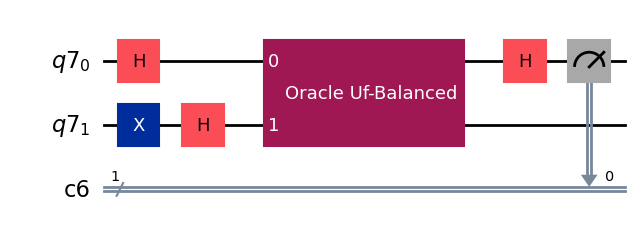

In [28]:
qc.draw("mpl")

In [31]:
simulator = Aer.get_backend('qasm_simulator')
compiled_circuit = transpile(qc, simulator)
#qobj = assemble(compiled_circuit)
results = simulator.run(compiled_circuit, shots=1024).result()
counts = results.get_counts()

In [33]:
#결과 출력
print("Measurement results:", counts)

Measurement results: {'1': 1024}


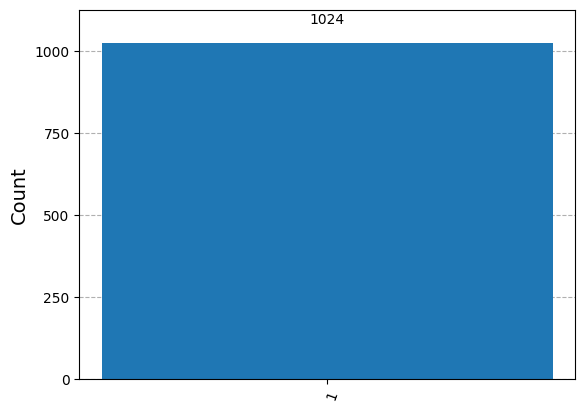

In [34]:
# 결과 히스토그램 출력
plot_histogram(counts)
###def